In [5]:
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=2'
# change directory to the dataset where our
# custom scripts are found
import tensorflow as tf
import logging
tf.get_logger().setLevel(logging.ERROR)

os.chdir("/kaggle/input/yamnt-improved/scripts")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa

from tqdm import tqdm 
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras import Model, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout,Input
from tensorflow.keras.losses import SparseCategoricalCrossentropy

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.applications import MobileNetV2

from params import Params
import features as features_lib
import warnings

warnings.filterwarnings('ignore')
# reset our working directory
os.chdir("/kaggle/working/")

2024-04-15 12:59:57.648701: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-15 12:59:57.648759: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-15 12:59:57.650329: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
tf.__version__

'2.15.0'

## Dataset

In [7]:
label_csv = '/kaggle/input/reduced-dataset/reduced_LA/modified_1500.csv' 
aud_dir = '/kaggle/input/reduced-dataset/reduced_LA/flac'


In [8]:
pd_data = pd.read_csv(label_csv)

In [9]:
map_class_to_id = {'bonafide': 0, 'spoof': 1}
map_spoof_type_to_id = {'A07':1, 'A08':2, 'A09':3, 'A10':4, 'A11':5, 'A12':6,'A13':7,'A14':8,'A15':9,'A16':10,'A17':11,'A18':12,'A19':13,'bonafide':14
                        }
class_id = pd_data['target'].apply(lambda name: map_class_to_id[name])
pd_data['target_val'] = class_id

spoof_id = pd_data['spoof_type'].apply(lambda name: map_spoof_type_to_id[name])
pd_data['spoof_val'] = spoof_id

full_path = pd_data['audio_ID'].apply(lambda row: os.path.join(aud_dir,row+'.flac'))
pd_data['audio_path'] = full_path

In [10]:
pd_data.head()

,speaker_ID,audio_ID,codec,transmission_geo,spoof_type,target,trim_status,subset,gender,target_val,spoof_val,audio_path
0,LA_0009,LA_E_9332881,alaw,ita_tx,A07,spoof,notrim,eval,female,1,1,/kaggle/input/reduced-dataset/reduced_LA/flac/...
1,LA_0009,LA_E_6866159,alaw,ita_tx,A07,spoof,notrim,eval,female,1,1,/kaggle/input/reduced-dataset/reduced_LA/flac/...
2,LA_0009,LA_E_4759417,alaw,sin_tx,A07,spoof,notrim,eval,female,1,1,/kaggle/input/reduced-dataset/reduced_LA/flac/...
3,LA_0009,LA_E_2667748,alaw,loc_tx,A07,spoof,notrim,eval,female,1,1,/kaggle/input/reduced-dataset/reduced_LA/flac/...
4,LA_0009,LA_E_8589971,alaw,loc_tx,A07,spoof,notrim,progress,female,1,1,/kaggle/input/reduced-dataset/reduced_LA/flac/...


In [11]:
pd_data=pd_data[['audio_path','target_val','spoof_val']]

In [12]:
#augmented data
augmented_dir = '/kaggle/input/asvspoof-la-reduced/flac_augmented_bonafide/flac_augmented_bonafide/'
augmented_files = os.listdir(path='/kaggle/input/asvspoof-la-reduced/flac_augmented_bonafide/flac_augmented_bonafide/')

In [13]:
augmented_path = map(lambda x: os.path.join(augmented_dir,x), augmented_files)
augmented_pd=pd.DataFrame({
    'audio_path' : augmented_path,
    'target_val' : [map_class_to_id['bonafide']]*len(augmented_files),
    'spoof_val' : [map_spoof_type_to_id['bonafide']]*len(augmented_files)
})
augmented_pd.head()

,audio_path,target_val,spoof_val
0,/kaggle/input/asvspoof-la-reduced/flac_augment...,0,14
1,/kaggle/input/asvspoof-la-reduced/flac_augment...,0,14
2,/kaggle/input/asvspoof-la-reduced/flac_augment...,0,14
3,/kaggle/input/asvspoof-la-reduced/flac_augment...,0,14
4,/kaggle/input/asvspoof-la-reduced/flac_augment...,0,14


In [14]:
pd_data = pd.concat([pd_data, augmented_pd], axis=0, ignore_index = True)

In [15]:
pd_data['target_val'].value_counts()

target_val
0    72740
1    70584
Name: count, dtype: int64

In [16]:
pd_data['spoof_val'].value_counts()

spoof_val
14    72740
10     5775
8      5774
9      5651
13     5626
11     5606
12     5460
6      5456
7      5438
2      5256
5      5219
4      5194
3      5122
1      5007
Name: count, dtype: int64

In [17]:
del augmented_pd
del augmented_files
del augmented_path

### Load the audios and extract the features

In [18]:
pd_data = pd_data.sample(frac=1, random_state=42).reset_index(drop=True)
filenames = pd_data['audio_path']
targets = pd_data['target_val']
spoof_types=pd_data['spoof_val']

main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets, spoof_types))
main_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [20]:
def load_wav_16k_mono(filename):
    data, sample_rate = librosa.load(filename, sr=16000, mono=True)
    return data

In [21]:
def load_wav_for_map(filename_tensor, targets, spoof_types):
    def load_wav(filename):
        filename_str = filename.numpy().decode('utf-8')
        return load_wav_16k_mono(filename_str)
    wav_data = tf.py_function(load_wav, [filename_tensor], tf.float32)
    return wav_data, targets, spoof_types

In [22]:
main_ds = main_ds.map(load_wav_for_map)
main_ds.element_spec

(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [23]:
params=Params()

In [24]:
def extract_features(wav_data, label, spoof_type):
    padded_audio = features_lib.pad_waveform(wav_data, params)
    log_mel_spectrogram,features = features_lib.waveform_to_log_mel_spectrogram_patches(
    padded_audio, params)
    num_features = tf.shape(features)[0]
    return (features,
            tf.repeat(label, num_features),
            tf.repeat(spoof_type, num_features))

In [25]:
# extract features
main_ds = main_ds.map(extract_features).unbatch()
main_ds.element_spec

(TensorSpec(shape=(96, 64), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [26]:
sample_filename = pd_data['audio_path'].iloc[0]
sample_label = pd_data['target_val'].iloc[0]
sample_spoof_type = pd_data['spoof_val'].iloc[0]

loaded_data, loaded_label, loaded_spoof_type = load_wav_for_map(sample_filename, sample_label, sample_spoof_type)
print("Loaded Data Shape:", loaded_data.shape)
print("Loaded Label:", loaded_label)
print("Loaded Spoof Type:", loaded_spoof_type)
# Test extracting embeddings from the loaded data
extracted_features, extracted_label, extracted_spoof_type = extract_features(loaded_data, loaded_label, loaded_spoof_type)
print("Extracted Embeddings ", extracted_features)
print("Extracted Label:", extracted_label)
print("Extracted Spoof Type:", extracted_spoof_type)

Loaded Data Shape: (21280,)
Loaded Label: 1
Loaded Spoof Type: 2
Extracted Embeddings  tf.Tensor(
[[[-3.0281105  -4.1065326  -5.0178676  ... -4.0767927  -4.5617285
   -4.2776775 ]
  [-3.3056538  -4.2211857  -5.3454385  ... -4.252352   -4.3270364
   -4.6996894 ]
  [-3.5429945  -3.904233   -3.752932   ... -4.13666    -4.121047
   -4.5555615 ]
  ...
  [-3.8801804  -3.5470622  -3.5537553  ...  0.83177376  0.42637947
    0.27633092]
  [-3.688837   -2.5369995  -2.5794556  ...  0.8410783   0.5273906
    0.28998873]
  [-1.8315427  -1.4739699  -1.6394336  ... -0.3558884  -0.6925866
   -0.66760737]]

 [[-1.4334266  -1.5303613  -2.0154598  ...  2.075899    1.8340409
    1.7962673 ]
  [-2.076341   -1.7076187  -1.8617035  ...  1.7893304   1.717861
    1.5148846 ]
  [-3.8155391  -2.9586074  -3.0729873  ...  0.61936766 -0.02028383
   -0.02784031]
  ...
  [-6.9077554  -6.9077554  -6.9077554  ... -6.9077554  -6.9077554
   -6.9077554 ]
  [-6.9077554  -6.9077554  -6.9077554  ... -6.9077554  -6.9077554
  

## Splitting the Data

In [28]:
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)

for train_index, remaining_index in stratified_split.split(filenames, targets):
    strat_train_indices = train_index
    remaining_indices = remaining_index

stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
for val_index, test_index in stratified_split.split(remaining_indices, targets.iloc[remaining_indices]):
    strat_val_indices = val_index
    strat_test_indices = test_index

# Filter the main dataset based on indices to create train, validation, and test datasets
train_ds = main_ds.enumerate().filter(lambda i, _: tf.reduce_any(tf.equal(i, strat_train_indices))).map(lambda i, data: data)
val_ds = main_ds.enumerate().filter(lambda i, _: tf.reduce_any(tf.equal(i, strat_val_indices))).map(lambda i, data: data)
test_ds = main_ds.enumerate().filter(lambda i, _: tf.reduce_any(tf.equal(i, strat_test_indices))).map(lambda i, data: data)

remove_filename = lambda feature, label, spoof_type: (feature, label)

train_ds = train_ds.map(remove_filename)
val_ds = val_ds.map(remove_filename)
test_ds = test_ds.map(remove_filename)

train_ds = train_ds.cache().batch(32)
val_ds = val_ds.cache().batch(32)
test_ds = test_ds.cache().batch(32)

In [29]:
print(train_ds)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 96, 64), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [30]:
print(train_ds.element_spec,test_ds.element_spec,val_ds.element_spec)

(TensorSpec(shape=(None, 96, 64), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None)) (TensorSpec(shape=(None, 96, 64), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None)) (TensorSpec(shape=(None, 96, 64), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))


In [58]:
vals = np.concatenate([t.numpy() for _, t in train_ds])
print(np.unique(vals))
print(np.count_nonzero(vals == 1))
print(vals.size - np.count_nonzero(vals))

[0 1]
36862
49132


In [59]:
vals = np.concatenate([t.numpy() for _, t in test_ds])
print(np.unique(vals))
print(np.count_nonzero(vals == 1))
print(vals.size - np.count_nonzero(vals))

[0 1]
12362
16303


In [60]:
vals = np.concatenate([t.numpy() for _, t in val_ds])
print(np.unique(vals))
print(np.count_nonzero(vals == 1))
print(vals.size - np.count_nonzero(vals))

[0 1]
12359
16306


# Model

In [32]:
#Instantiate MobileNetV2 model
mobilenetv2_model = MobileNetV2()

mobilenetv2_model.summary()

14536120/14536120 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,538,984 (13.50 MB)

 Trainable params: 3,504,872 (13.37 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [33]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

#Define callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)


In [34]:
def define_model(frame_size,my_classes):
    l2_strength=0.01
    
    input_features = Input(shape=(frame_size[0], frame_size[1], 1), name='input_features')
    
    # MobileNetV2 base
    base_model = MobileNetV2(input_shape=(frame_size[0], frame_size[1], 1), include_top=False, weights=None)
    x = base_model(input_features)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(l2_strength))(x)
    x = Dropout(rate=0.5)(x)
#    x = Dense(512, activation='relu')(x)
#    x = Dropout(rate=0.5)(x)
    #Dense output layer for binary classification
    outputs = Dense(len(my_classes), activation='relu', name='output')(x)

    model = Model(inputs=input_features, outputs=outputs, name='MobileNetV2_Binary')
    
    return model

In [35]:
frame_size = (96, 64)
my_classes = ['bonafide','spoof']

custom_model = define_model(frame_size,my_classes)

#Set the MobileNetV2 layers to be trainable
for layer in custom_model.layers:
    if layer.name.startswith('mobilenetv2'):
        layer.trainable = True
    else:
        layer.trainable = False
custom_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    metrics=['accuracy']
)
custom_model.summary()

Model: "MobileNetV2_Binary"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_features (InputLayer)     │ (None, 96, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_96             │ (None, 3, 2, 1280)     │     2,257,408 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,919,426 (11.14 MB)

 Trainable params: 2,223,296 (8.48 MB)

 Non-trainable params: 696,130 (2.66 MB)

In [37]:
history = custom_model.fit(train_ds,
                            epochs=100,
                            batch_size=32,
                            validation_data=val_ds,
                            callbacks=[early_stopping, reduce_lr]
                            )

Epoch 1/100


I0000 00:00:1713187800.155988     354 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


      3/Unknown 56s 63ms/step - accuracy: 0.5139 - loss: 0.7852

W0000 00:00:1713187841.964515     354 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


   2688/Unknown 2874s 1s/step - accuracy: 0.7135 - loss: 0.5357  

W0000 00:00:1713190660.878624     354 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713190664.491757     357 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713191891.383069     356 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2688/2688 ━━━━━━━━━━━━━━━━━━━━ 4105s 2s/step - accuracy: 0.7135 - loss: 0.5357 - val_accuracy: 0.5688 - val_loss: 1.0147 - learning_rate: 0.0010
Epoch 2/100
2688/2688 ━━━━━━━━━━━━━━━━━━━━ 70s 26ms/step - accuracy: 0.8066 - loss: 0.4064 - val_accuracy: 0.7709 - val_loss: 0.5752 - learning_rate: 0.0010
Epoch 3/100
2688/2688 ━━━━━━━━━━━━━━━━━━━━ 70s 26ms/step - accuracy: 0.8447 - loss: 0.3446 - val_accuracy: 0.6865 - val_loss: 1.7689 - learning_rate: 0.0010
Epoch 4/100
2688/2688 ━━━━━━━━━━━━━━━━━━━━ 70s 26ms/step - accuracy: 0.8610 - loss: 0.3111 - val_accuracy: 0.8060 - val_loss: 0.6581 - learning_rate: 0.0010
Epoch 5/100
2688/2688 ━━━━━━━━━━━━━━━━━━━━ 71s 27ms/step - accuracy: 0.8744 - loss: 0.2808 - val_accuracy: 0.8739 - val_loss: 0.3231 - learning_rate: 0.0010
Epoch 6/100
2688/2688 ━━━━━━━━━━━━━━━━━━━━ 70s 26ms/step - accuracy: 0.8853 - loss: 0.2543 - val_accuracy: 0.8520 - val_loss: 0.3866 - learning_rate: 0.0010
Epoch 7/100
2688/2688 ━━━━━━━━━━━━━━━━━━━━ 70s 26ms/step - accuracy: 0

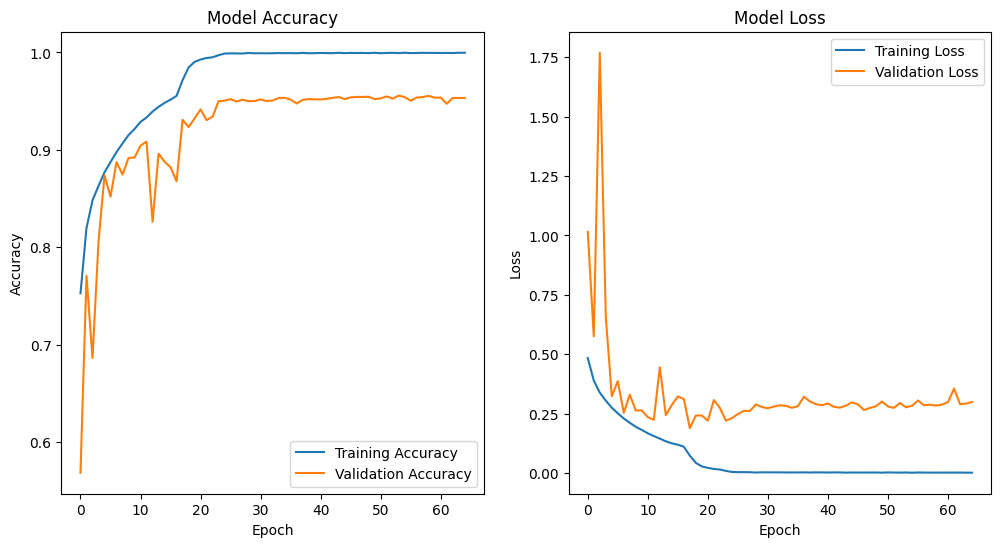

In [38]:
# Plot training & validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [39]:
loss, accuracy = custom_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

896/896 ━━━━━━━━━━━━━━━━━━━━ 1244s 1s/step - accuracy: 0.9563 - loss: 0.2632
Loss:  0.27016574144363403
Accuracy:  0.9556253552436829


In [40]:
predictions=custom_model.predict(test_ds,verbose=1)

     25/Unknown 3s 6ms/step

W0000 00:00:1713197590.403497     354 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


896/896 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step


W0000 00:00:1713197597.512836     356 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [41]:
y_true = np.concatenate([t.numpy() for _, t in test_ds])

In [42]:
conf_matrix = confusion_matrix(y_true, predictions.argmax(axis=1))
conf_matrix

array([[15657,   646],
       [  626, 11736]])

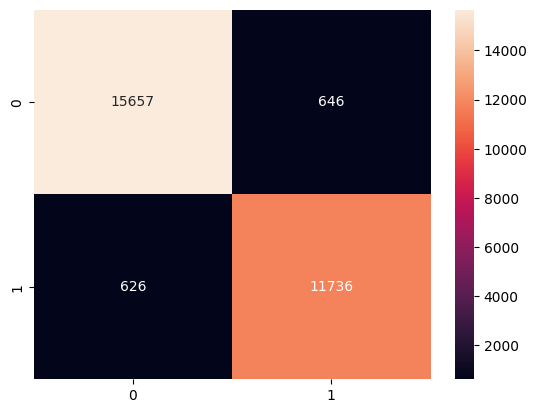

In [43]:
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.show()

# **Model - Audio Input**

In [44]:
import os
import uuid

# Generate a unique identifier for the file name
unique_id = str(uuid.uuid4())
save_dir = '/kaggle/working/model_{}'.format(unique_id)

while os.path.exists(save_dir):
    unique_id = str(uuid.uuid4())
    save_dir = '/kaggle/working/model_{}'.format(unique_id)

tf.saved_model.save(custom_model, save_dir)

In [45]:
!zip -r augmentedv2.zip {'/kaggle/working/model_669cf0ed-f4cf-4b94-a8e1-8e947adbe84b'}

  adding: kaggle/working/model_669cf0ed-f4cf-4b94-a8e1-8e947adbe84b/ (stored 0%)
  adding: kaggle/working/model_669cf0ed-f4cf-4b94-a8e1-8e947adbe84b/assets/ (stored 0%)
  adding: kaggle/working/model_669cf0ed-f4cf-4b94-a8e1-8e947adbe84b/variables/ (stored 0%)
  adding: kaggle/working/model_669cf0ed-f4cf-4b94-a8e1-8e947adbe84b/variables/variables.index (deflated 77%)
  adding: kaggle/working/model_669cf0ed-f4cf-4b94-a8e1-8e947adbe84b/variables/variables.data-00000-of-00001 (deflated 9%)
  adding: kaggle/working/model_669cf0ed-f4cf-4b94-a8e1-8e947adbe84b/fingerprint.pb (stored 0%)
  adding: kaggle/working/model_669cf0ed-f4cf-4b94-a8e1-8e947adbe84b/saved_model.pb (deflated 91%)


In [46]:
from tensorflow.keras.layers import Layer

In [47]:
class ReduceMeanLayer(tf.keras.layers.Layer):
  def __init__(self, axis=0, **kwargs):
    super(ReduceMeanLayer, self).__init__(**kwargs)
    self.axis = axis

  def call(self, input):
    return tf.math.reduce_mean(input, axis=self.axis)

In [48]:
class FeatureExtractionLayer(Layer):
    def __init__(self, frame_size, params, **kwargs):
        super(FeatureExtractionLayer, self).__init__(**kwargs)
        self.frame_size = frame_size
        self.params = params

    def build(self, input_shape):
        super(FeatureExtractionLayer, self).build(input_shape)

    def call(self, wav_data):
        padded_audio = features_lib.pad_waveform(wav_data, self.params)
        
        log_mel_spectrogram, features = features_lib.waveform_to_log_mel_spectrogram_patches(
            padded_audio, self.params)
        
        return features

    def compute_output_shape(self, input_shape):
        return input_shape[0], self.frame_size[0], self.frame_size[1], 1

In [49]:
feature_extraction_layer = FeatureExtractionLayer(frame_size, params, name='feature_extraction')

input_audio = Input(shape=(), dtype=tf.float32, name='input_audio')

features_output = feature_extraction_layer(input_audio)
serving_outputs = custom_model(inputs=features_output)  
serving_outputs = ReduceMeanLayer(axis=0, name='classifier')(serving_outputs)

serving_model = tf.keras.Model(input_audio, serving_outputs)
serving_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_audio (InputLayer)        │ (None)                 │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ feature_extraction              │ (None, 96, 64, 1)      │             0 │
│ (FeatureExtractionLayer)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV2_Binary (Functional) │ (None, 2)              │     2,919,426 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier (ReduceMeanLayer)    │ (2)                    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,919,426 (11.14 MB)

 Trainable params: 2,223,296 (8.48 MB)

 Non-trainable params: 696,130 (2.66 MB)

In [50]:
saved_model_path = './augmented_spoof_detection_yamnet_v2'
tf.saved_model.save(serving_model, saved_model_path)

In [51]:
!zip -r augmented_spoof_detection_yamnet_v2.zip {'/kaggle/working/augmented_spoof_detection_yamnet_v2'}

  adding: kaggle/working/augmented_spoof_detection_yamnet_v2/ (stored 0%)
  adding: kaggle/working/augmented_spoof_detection_yamnet_v2/assets/ (stored 0%)
  adding: kaggle/working/augmented_spoof_detection_yamnet_v2/variables/ (stored 0%)
  adding: kaggle/working/augmented_spoof_detection_yamnet_v2/variables/variables.index (deflated 77%)
  adding: kaggle/working/augmented_spoof_detection_yamnet_v2/variables/variables.data-00000-of-00001 (deflated 10%)
  adding: kaggle/working/augmented_spoof_detection_yamnet_v2/fingerprint.pb (stored 0%)
  adding: kaggle/working/augmented_spoof_detection_yamnet_v2/saved_model.pb (deflated 92%)


In [54]:
loaded_model = tf.saved_model.load('/kaggle/working/augmented_spoof_detection_yamnet_v2')

In [55]:
serving_default = loaded_model.signatures['serving_default']
print("Inputs:", serving_default.structured_input_signature)
print("Outputs:", serving_default.structured_outputs)

Inputs: ((), {'inputs': TensorSpec(shape=(None,), dtype=tf.float32, name='inputs')})
Outputs: {'output_0': TensorSpec(shape=(2,), dtype=tf.float32, name='output_0')}


In [56]:
my_classes=['bonafinde','spoof']

In [57]:
input_data = {'inputs': load_wav_16k_mono(sample_filename)}
result = loaded_model.signatures['serving_default'](**input_data)
output_tensor = result['output_0']
predicted_index = tf.argmax(output_tensor, axis=-1).numpy()
bonafide_or_spoof = my_classes[predicted_index]
print("Predicted class:", bonafide_or_spoof)

Predicted class: spoof


W0000 00:00:1713198192.874110     357 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
